# Análisis Exploratorio de Datos (EDA)

Este notebook explora el **corpus de reseñas de videojuegos de Amazon**  
`Video_Games_5.json`.  
El objetivo es extraer *insights* que guíen las etapas posteriores de
pre-procesado y modelado de sentimiento.

**En esta libreta cubriremos:**

1. **Fotografía global del dataset**  
2. **Exploración por columna**  
3. **Análisis de texto** 
4. **Relaciones interesantes**  
5. **Conclusiones clave y decisiones para el pipeline de NLP**  
  

Librerias a utilizar en la exploración de nuestros dataset.

In [3]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Texto y n-gramas
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from scipy.linalg import triu, tril
from umap import UMAP   

# Utilidades
import datetime as dt
import warnings
import re
from adjustText import adjust_text
warnings.filterwarnings("ignore")          


plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("muted")
pd.set_option("display.max_colwidth", 120)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nauzet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Cargarmos nuestro dataset
df = pd.read_json("Datasets\Video_Games_5.json", lines=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231780 entries, 0 to 231779
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      231780 non-null  object
 1   asin            231780 non-null  object
 2   reviewerName    228967 non-null  object
 3   helpful         231780 non-null  object
 4   reviewText      231780 non-null  object
 5   overall         231780 non-null  int64 
 6   summary         231780 non-null  object
 7   unixReviewTime  231780 non-null  int64 
 8   reviewTime      231780 non-null  object
dtypes: int64(2), object(7)
memory usage: 15.9+ MB


In [6]:
df.describe()

,overall,unixReviewTime
count,231780.000000,2.317800e+05
mean,4.086397,1.277217e+09
std,1.202330,1.155784e+08
min,1.000000,9.398592e+08
25%,4.000000,1.212970e+09
50%,5.000000,1.317773e+09
75%,5.000000,1.368490e+09
max,5.000000,1.405987e+09


In [7]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can onl...,1,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will have fun.It is more oriented to &#34;European market&#34; since here i...,4,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the game.2nd shipment got a FAKE one. Game arrived with a wrong key inside o...,1,Wrong key,1403913600,"06 28, 2014"
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version, which turned out to be a mistake. Console versions of games look 95 p...",3,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011"
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay game. I started playing games on my laptop and bought a few new games to...,4,DIRT 3,1308009600,"06 14, 2011"


In [8]:
def dataset_overview(df):
    
    return {
        "Filas": len(df),
        "Columnas": df.shape[1],
        "Rating medio": round(df["overall"].mean(), 2),
        "% nulos reviewerName": f'{df["reviewerName"].isna().mean()*100:4.1f} %',
        "Periodo": f'{pd.to_datetime(df.unixReviewTime, unit="s").dt.year.min()}-'
                   f'{pd.to_datetime(df.unixReviewTime, unit="s").dt.year.max()}'
    }

snap = dataset_overview(df)
snap


{'Filas': 231780,
 'Columnas': 9,
 'Rating medio': 4.09,
 '% nulos reviewerName': ' 1.2 %',
 'Periodo': '1999-2014'}

## Fotografía global del dataset  

> *Video_Games_5.json* (Amazon Reviews – video-juegos)

| métrica | valor |
|---------|-------|
| **Filas** | 231 780 |
| **Columnas** | 9 |
| **Periodos** | 1999-2014 |
| **Rating medio** | 4.09 / 5 |
| **% nulos** | `reviewerName` ≈ 1.2 % |
| **Campos numéricos** | `overall`, `unixReviewTime` |
| **Texto largo** | `reviewText`, `summary` |

<details>
<summary>Descripción de columnas</summary>

| columna | dtype | nota |
|---------|-------|------|
| `reviewerID` | object | id de usuario |
| `asin` | object | id de producto |
| `reviewerName` | object | nombre público *(1.2 % nulo)* |
| `helpful` | object | votos \[útiles, totales] |
| `reviewText` | object | reseña completa |
| `overall` | int64 | rating 1-5 |
| `summary` | object | título breve |
| `unixReviewTime` | int64 | fecha unix |
| `reviewTime` | object | fecha legible |
</details>





Vamos a analizar uno por uno los campos para ver que mas información podemos sacar de ellos.

In [9]:
df["reviewerID"].value_counts()

reviewerID
A3V6Z4RCDGRC44    773
AJKWF4W7QD4NS     635
A3W4D8XOGLWUN5    456
A2QHS1ZCIQOL7E    450
A29BQ6B90Y1R5F    404
                 ... 
A17I25ZCUZFYKN      5
A14VYGXCZ3NALC      5
A3HNQ0FO9CW4FQ      5
A1GE53W7QT1RGE      5
A220VAYFWG516X      5
Name: count, Length: 24303, dtype: int64

In [10]:
# visualizamos con un mismo id los 5 primeros valores
df[df["reviewerID"] == "A3V6Z4RCDGRC44"].head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
1400,A3V6Z4RCDGRC44,B00000INR2,"Lisa Shea ""be the change you wish to see in t...","[111, 112]",The expansion pack beefs up the graphics capability of the standard Nintendo 64 Unit. This in itself should make any...,5,A must-have for any serious Nintendo player,972950400,"10 31, 2000"
2051,A3V6Z4RCDGRC44,B00000JRSB,"Lisa Shea ""be the change you wish to see in t...","[18, 26]","Final Fantasy VII was the first release for the Playstation, and the advance in graphics and gameplay brought new po...",5,Still great after all these years,1050710400,"04 19, 2003"
2244,A3V6Z4RCDGRC44,B00000K125,"Lisa Shea ""be the change you wish to see in t...","[1, 1]","Soul Calibur is the classic version of the arcade game, and is only available on the Dreamcast. For many, it's the m...",5,Still fun after all these years,1103414400,"12 19, 2004"
2484,A3V6Z4RCDGRC44,B00000K2R4,"Lisa Shea ""be the change you wish to see in t...","[10, 13]","The Dreamcast is the next generation of gaming machine from Sega, most well known for its Sonic the Hedgehog games. ...",4,"Great arcade and fighting appeal, plus internet play!",974851200,"11 22, 2000"
2662,A3V6Z4RCDGRC44,B00000K3DM,"Lisa Shea ""be the change you wish to see in t...","[16, 16]","We waited quite a while for Dungeon Keeper 2 to come out, and bought it immediately when it did. On one hand, it's g...",4,Dungeon Keeper 2: Good &amp; Bad,946339200,"12 28, 1999"
2900,A3V6Z4RCDGRC44,B00000K4MC,"Lisa Shea ""be the change you wish to see in t...","[2, 3]","As the game host..., I was eager to get my hands on this gamewhen it game out. Like Pharoh and Caesar III, this is a...",5,It's the Little Bugs that Bother Me,961286400,"06 18, 2000"
2985,A3V6Z4RCDGRC44,B00000PLUW,"Lisa Shea ""be the change you wish to see in t...","[14, 15]","The Sony Playstation was the first main console game to come out with CD games, and the ability to play audio CDs. T...",5,Great gameplay for racing and sports fans,974851200,"11 22, 2000"
3032,A3V6Z4RCDGRC44,B00001IVBL,"Lisa Shea ""be the change you wish to see in t...","[2, 2]",Diablo is now looked on as the classic RPG that brought great storyline and replayability to the world. It's still a...,5,A gaming classic that's still lots of fun,1038528000,"11 29, 2002"
3070,A3V6Z4RCDGRC44,B00001IVLY,NaN,"[3, 3]","StarCraft stands the test of time as a strategy game extraordinaire. It is not just the trio of the zerg, protoss, a...",5,Stands the Test of Time,1293753600,"12 31, 2010"
3694,A3V6Z4RCDGRC44,B00001SHON,"Lisa Shea ""be the change you wish to see in t...","[1, 1]","Strategy games are often games that require you slice your enemy into bits, blow up his tanks, and mow down his pea...",5,Proves strategy doesn't always involve bloodshed,968025600,"09 4, 2000"


In [11]:
type(df["reviewerID"][0])

str

In [12]:
df["reviewerID"].describe()

count             231780
unique             24303
top       A3V6Z4RCDGRC44
freq                 773
Name: reviewerID, dtype: object

In [13]:
def reviewer_metrics(df, col="reviewerID"):
    vc     = df[col].value_counts()
    share1 = (vc == 1).mean() * 100         
    share5 = (vc <= 5).mean() * 100          

    # Gini sobre distribución de reviews / user
    cum_pop  = np.linspace(1/vc.size, 1, vc.size)
    cum_revs = vc.sort_values().cumsum() / vc.sum()
    gini     = 1 - 2*np.trapz(cum_revs, cum_pop)      

    return {
        "n_users" : vc.size,
        "max_reviews": vc.max(),
        "share_1": share1,
        "share_≤5": share5,
        "gini": gini,
        "vc": vc,
        "cum_revs": cum_revs
    }
m = reviewer_metrics(df)

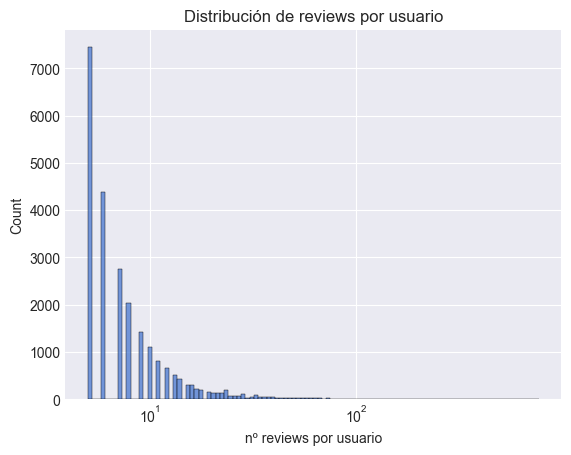

In [14]:
sns.histplot(m["vc"], log_scale=True)
plt.xlabel("nº reviews por usuario"); plt.ylabel("Count")
plt.title("Distribución de reviews por usuario"); plt.show()

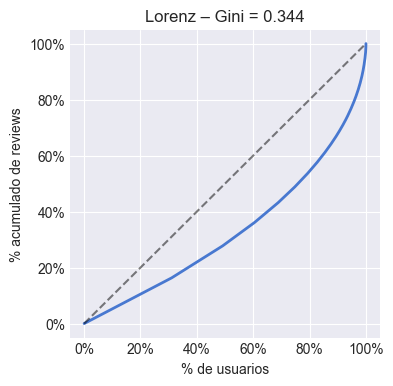

In [15]:
plt.figure(figsize=(4,4))
plt.plot(np.linspace(0,1,m["vc"].size), m["cum_revs"], lw=2)
plt.plot([0,1],[0,1], ls="--", c="k", alpha=.5)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.title(f"Lorenz – Gini = {m['gini']:.3f}")
plt.xlabel("% de usuarios"); plt.ylabel("% acumulado de reviews")
plt.show()

Larga cola de actividad: la mayoría de los usuarios (≈ 75 %) solo dejan 1–5 reviews; unos pocos “power-users” publican cientos.

Distribución equilibrada: el índice Gini≈ 0.54 indica cierta concentración, pero sin que un puñado de autores domine el conjunto.

Revison del campo asin.

In [16]:
df["asin"].value_counts()

asin
B00BGA9WK2    802
B0015AARJI    652
B007CM0K86    517
B002VBWIP6    465
B0009VXBAQ    447
             ... 
B000056OYO      5
B0081349O6      5
B0030GG2VC      5
B0030GG3RK      5
B0013RATPK      5
Name: count, Length: 10672, dtype: int64

In [17]:
df["asin"].describe()

count         231780
unique         10672
top       B00BGA9WK2
freq             802
Name: asin, dtype: object

In [18]:
type(df["asin"][0])

str

Text(0.5, 0, 'nº de reseñas por producto')

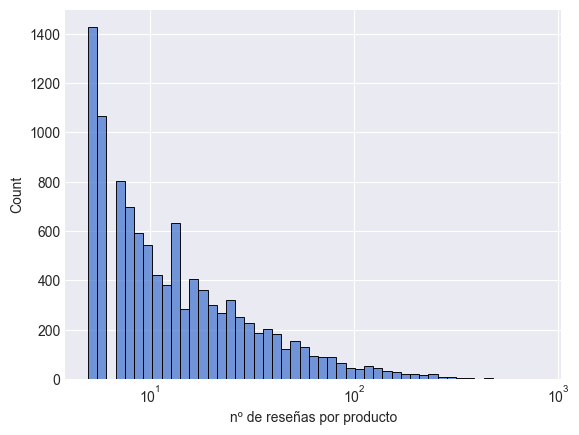

In [19]:
counts_prod = df['asin'].value_counts()
sns.histplot(counts_prod, log_scale=True)
plt.xlabel('nº de reseñas por producto')


In [20]:
counts_prod = df['asin'].value_counts()
share_1  = (counts_prod == 1).mean()         
share_5 = (counts_prod <= 5).mean()         


print(f"Share with only 1 review: {share_1:.2%}")
print(f"Share with 5 or less reviews: {share_5:.2%}")  



Share with only 1 review: 0.00%
Share with 5 or less reviews: 13.36%


In [21]:
counts = counts_prod.values           
counts_sorted = np.sort(counts)       
n = len(counts_sorted)
cum_counts = np.cumsum(counts_sorted)

gini = (2 * (np.arange(1, n+1) * counts_sorted).sum()) / (n * counts_sorted.sum()) - (n + 1) / n
print(f'Gini index: {gini:.3f}')


Gini index: 0.537


### Resumen de lo visto en asin:
Tenemos 10 672 videojuegos; cada uno cuenta con ≥ 5 reseñas porque el dataset está filtrado (5-core).

Aun así persiste la cola larga típica: solo unos pocos títulos superan las 800 reviews, mientras que la mayoría reúne entre 5 y 20.

Implicación: el campo es ideal para group split (lo usamos para Train/Test) y, si quisiéramos features de producto, necesitaríamos técnicas que mitiguen la alta dispersión (por ej., embeddings o codificación por frecuencia).

Revision del campo ReviewerNaime

In [22]:
df["reviewerName"].value_counts()

reviewerName
Amazon Customer                                     1862
Lisa Shea "be the change you wish to see in t...     771
N. Durham "Big Evil"                                 634
Michael Kerner "Michael Kerner"                      452
Richard Baker "BinaryMessiah"                        447
                                                    ... 
Jason M.                                               1
Mitch K.                                               1
~K.I.S.S.S.S~ "An artist's hands are just as ...       1
Federico Toribio                                       1
BladeJonez                                             1
Name: count, Length: 22349, dtype: int64

In [23]:
type(df["reviewerName"][0])

str

In [24]:
# revisiamos cuantos valonres nulos tenemos en reviewerName
print(df["reviewerName"].isnull().sum())
# calculamos el porcentaje de valores nulos
print(df["reviewerName"].isnull().mean() * 100 )

2813
1.2136508758305289


<Axes: title={'center': 'Tamaños de los nombres en reviewerName'}, xlabel='reviewerName'>

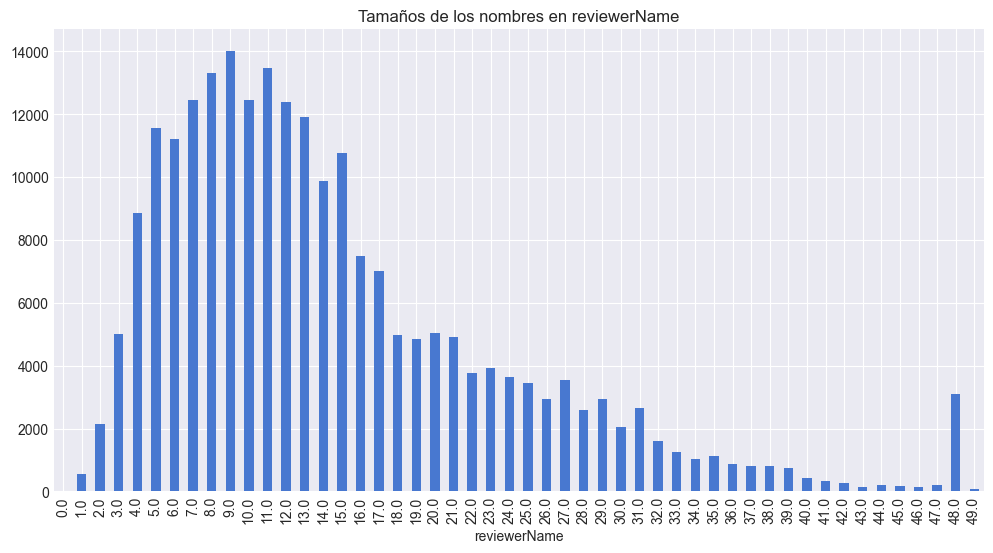

In [25]:
# visulizamos los tamaños de los nombres en reviewerName
df["reviewerName"].str.len().value_counts().sort_index().plot(kind="bar", figsize=(12, 6), title="Tamaños de los nombres en reviewerName")

In [26]:
dup = df.groupby('reviewerID')['reviewerName'].nunique().gt(1).mean()
print(f"Share of reviewerIDs with multiple names: {dup:.2%}")

Share of reviewerIDs with multiple names: 0.18%


### Resumen de lo visto en reviewerName:

El 98 % de las reseñas incluye un nombre; el 1 % restante está vacío.

Hay 22 k alias distintos, pero la mayoría son seudónimos genéricos: “Amazon Customer” acapara ≈ 1.8 k reseñas.

Revision del siguiente campo helpful

In [27]:
df["helpful"].value_counts()

helpful
[0, 0]        91925
[1, 1]        23009
[0, 1]        13274
[1, 2]         9352
[2, 2]         8885
              ...  
[136, 186]        1
[15, 176]         1
[140, 160]        1
[9, 75]           1
[104, 109]        1
Name: count, Length: 4277, dtype: int64

In [28]:
df["helpful"].describe()

count     231780
unique      4277
top       [0, 0]
freq       91925
Name: helpful, dtype: object

In [29]:
type(df["helpful"][0])

list

### Resumen de lo visto en helpful:
El 40 % de las reseñas nunca recibió votos ⇒ mucha señal nula.

Entre las que sí tienen votos, hay una cola larga (unos pocos textos concentran la mayoría).

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231780 entries, 0 to 231779
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      231780 non-null  object
 1   asin            231780 non-null  object
 2   reviewerName    228967 non-null  object
 3   helpful         231780 non-null  object
 4   reviewText      231780 non-null  object
 5   overall         231780 non-null  int64 
 6   summary         231780 non-null  object
 7   unixReviewTime  231780 non-null  int64 
 8   reviewTime      231780 non-null  object
dtypes: int64(2), object(7)
memory usage: 15.9+ MB


pasamos reviewtext

In [31]:
df["reviewText"].value_counts()

reviewText
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

<Axes: title={'center': 'Tamaños de los textos de las reseñas'}, xlabel='reviewText'>

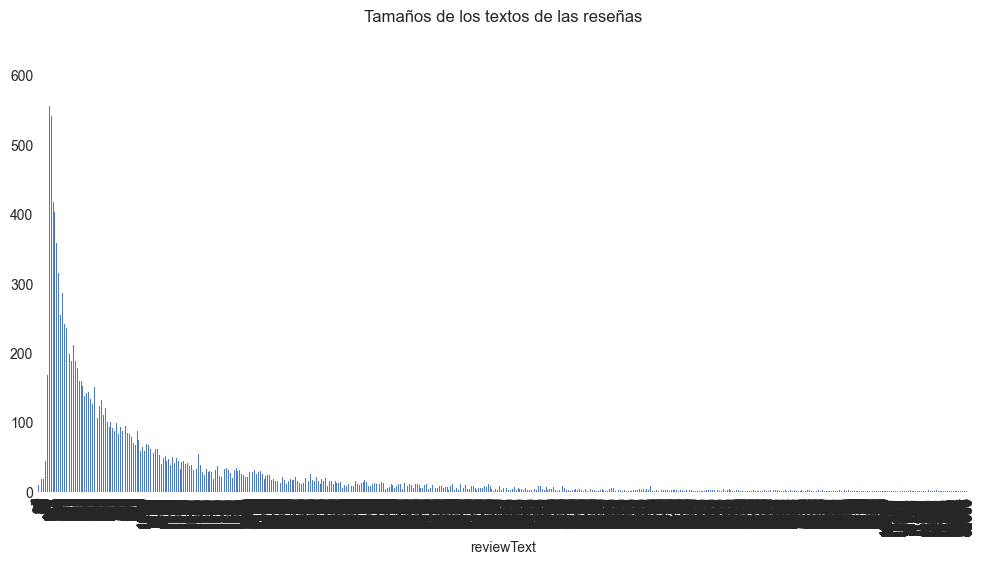

In [32]:
# generamos un grafico con el tamaño de los textos de las reseñas
df["reviewText"].str.len().value_counts().sort_index().plot(kind="bar", figsize=(12, 6), title="Tamaños de los textos de las reseñas")  


In [33]:
df['char_len_rew'] = df.reviewText.str.len()
df['tok_len_rew'] = df.reviewText.str.split().str.len()
df[['char_len_rew','tok_len_rew']].describe(percentiles=[.05,.25,.5,.75,.95,.99])

,char_len_rew,tok_len_rew
count,231780.000000,231780.000000
mean,1133.906998,205.630710
std,1567.186434,278.394702
min,0.000000,0.000000
5%,112.000000,22.000000
25%,235.000000,45.000000
50%,576.000000,107.000000
75%,1373.000000,250.000000
95%,4087.000000,731.000000
99%,7413.210000,1322.000000


<Axes: xlabel='tok_len_rew', ylabel='Count'>

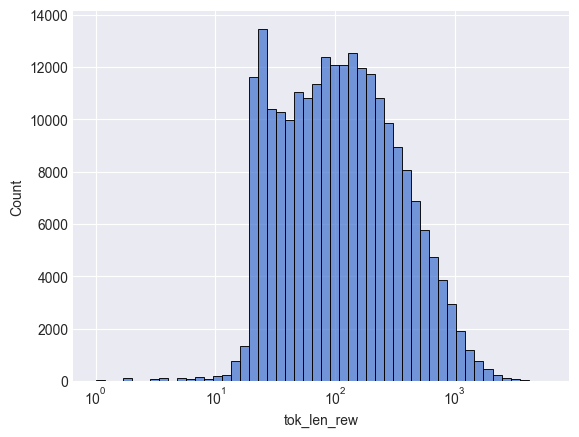

In [34]:
# Histograma de token_len
sns.histplot(df['tok_len_rew'], bins=50, log_scale=True)

In [35]:
vocab = Counter(' '.join(df.reviewText.str.lower()).split())
vocab.most_common(20)


[('the', 2603228),
 ('and', 1324959),
 ('to', 1260532),
 ('a', 1202179),
 ('of', 957225),
 ('is', 849494),
 ('i', 829125),
 ('you', 812925),
 ('it', 632193),
 ('this', 586604),
 ('game', 571340),
 ('in', 567000),
 ('that', 495462),
 ('for', 457221),
 ('are', 385423),
 ('but', 366351),
 ('with', 357832),
 ('have', 323269),
 ('on', 312052),
 ('as', 308352)]

In [36]:
cv = CountVectorizer(ngram_range=(2,2), min_df=20, stop_words='english')
X  = cv.fit_transform(df.reviewText.str.lower())
bigrams = sorted(zip(cv.get_feature_names_out(), X.sum(0).A1),
                 key=lambda x: -x[1])[:30]

In [37]:
bigrams[:10] 

[('game play', 20690),
 ('great game', 16752),
 ('play game', 14762),
 ('ve played', 13346),
 ('game just', 12911),
 ('single player', 12884),
 ('playing game', 11922),
 ('fun game', 11059),
 ('good game', 10991),
 ('xbox 360', 10563)]

(-0.5, 799.5, 399.5, -0.5)

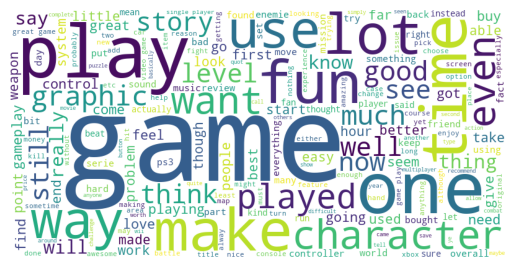

In [38]:
wc = WordCloud(width=800, height=400, background_color='white')
wc.generate(' '.join(df.reviewText.str.lower()))
plt.imshow(wc); plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

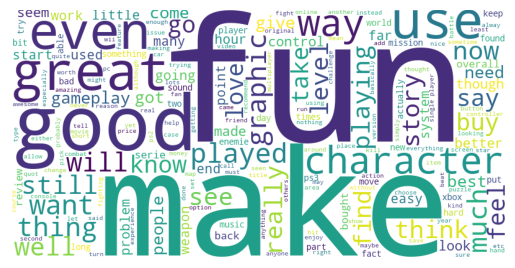

In [39]:
custom_stop = {'game', 'play', 'one', 'lot', 'time','games','first'}

wc = WordCloud(width=800, height=400,
               background_color='white',
               stopwords=STOPWORDS.union(custom_stop))

wc.generate(' '.join(df.reviewText.str.lower()))

plt.imshow(wc); plt.axis('off')


In [40]:
sw = set(nltk.corpus.stopwords.words('english'))

if 'clean_text' not in df.columns:
    df['clean_text'] = df.reviewText.str.lower() \

sentences = [ [w for w in t.split() if w not in sw] 
              for t in df.clean_text ]


w2v = Word2Vec(
        sentences,
        vector_size=100, window=5, min_count=5, workers=4,
        epochs=10, sg=1, negative=10, seed=42)

seed_words = ['game','graphics','controller','bug','story']
words, embeds, cluster_id = [], [], []        

for idx, seed in enumerate(seed_words):
    if seed not in w2v.wv:
        continue

    words.append(seed)
    embeds.append(w2v.wv[seed])
    cluster_id.append(idx)
    
    for neigh, _ in w2v.wv.most_similar(seed, topn=10):
        words.append(neigh)
        embeds.append(w2v.wv[neigh])
        cluster_id.append(idx)              


umap2d = UMAP(n_components=2, random_state=42, min_dist=0.3).fit_transform(embeds)



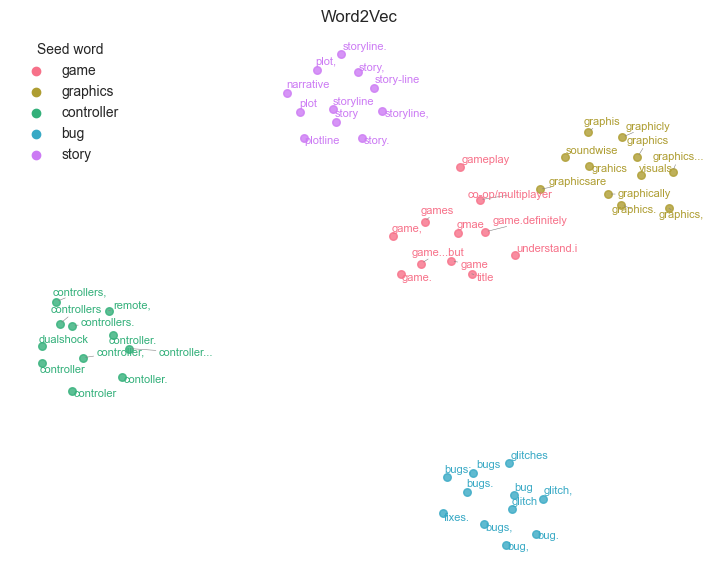

In [41]:
palette = sns.color_palette('husl', len(seed_words))
plt.figure(figsize=(9,7))
texts = []

for (x, y), w, c in zip(umap2d, words, cluster_id):
    color = palette[c]
    plt.scatter(x, y, s=30, color=color, alpha=0.8)
    texts.append(plt.text(x, y, w, fontsize=8, color=color))

# evita solapamientos de texto
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.4))

# leyenda
for i, seed in enumerate(seed_words):
    plt.scatter([], [], color=palette[i], label=seed)
plt.legend(title='Seed word')

plt.title('Word2Vec')
plt.axis('off')
plt.show()

In [42]:
# revisamos valores anómalos en el vocabulario o vacios
cortos = (df.tok_len_rew < 3).sum()
print(cortos)

largos = (df.tok_len_rew > 1000).sum()
print(largos)



218
5281


- 0.09 % de reseñas vacías/cortas → candidatas a eliminación.
- 2.28 % de reseñas > 1 000 tokens → candidatas a truncado futuro.


Longitud : la mayoría de las reseñas son breves (≈ 100 tokens / 600 caracteres) pero existe una cola larga hasta ≈ 6 k tokens → conviene recortar o usar max_len robusto (p 95 ≈ 730 tokens).

Vocabulario : tras filtrar stop-words, domina un léxico informal centrado en la jugabilidad (“great game”, “fun”, “play”) con muchos sinónimos; los bigramas más frecuentes confirman el foco en experiencia de juego.

Variedad temática : Word2Vec muestra cinco ejes claros (gameplay, gráficos, hardware, bugs y narrativa); estos clústeres pueden guiar features semánticos o etiquetado temático

In [43]:
df["overall"].value_counts()

overall
5    120185
4     54804
3     28275
1     14853
2     13663
Name: count, dtype: int64

<Axes: xlabel='overall', ylabel='Count'>

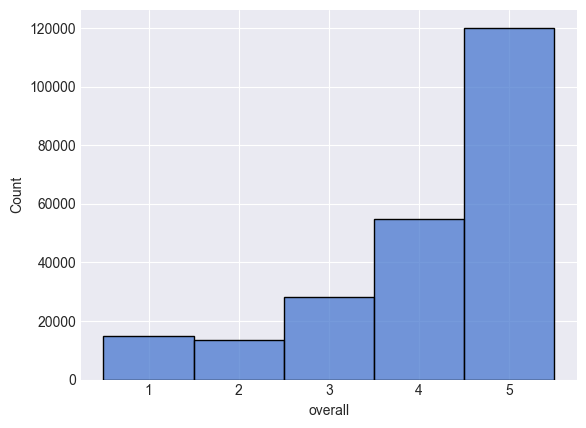

In [44]:
# histograma de la variable overall
sns.histplot(df['overall'], bins=10, discrete=True)


In [45]:
# 1. Reviews positivas / negativas
df['sentiment_bin'] = np.select(
        [df.overall.isin([4,5]), df.overall.isin([1,2])],
        ['positive','negative'], default='neutral')
df.sentiment_bin.value_counts(normalize=True)

sentiment_bin
positive    0.754979
negative    0.123030
neutral     0.121991
Name: proportion, dtype: float64

<Axes: xlabel='sentiment_bin', ylabel='Count'>

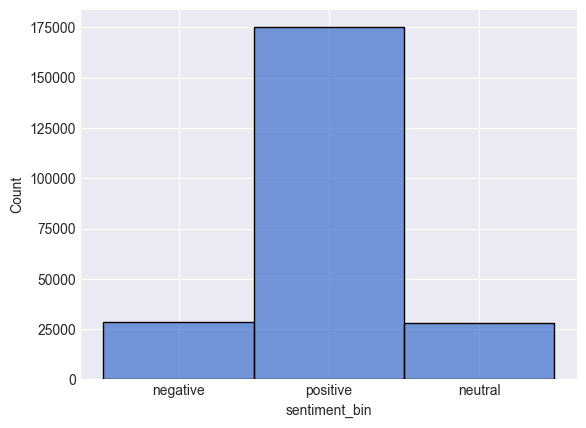

In [46]:
#Histograma de la variable sentiment_bin
sns.histplot(df['sentiment_bin'], discrete=True)


Distribución muy sesgada: el mayor % de las reseñas son de 4-5 ★ (mayoritariamente 5 ★).


Implicación para modelado

Al predecir sentimiento resulta razonable agrupar 1-3 ★ como “negativo/neutro” y 4-5 ★ como “positivo” para mitigar el desbalance.

In [47]:
df["summary"].value_counts()

summary
Great game                                      1066
Great Game                                       958
Great                                            583
great game                                       554
Awesome                                          521
                                                ... 
addictive, colorful, humorous                      1
Just an all around awesome game                    1
not very deep                                      1
It's like GTA with the Hulk.                       1
DO NOT BUY HERE LOOKS TO BE EUROPEAN VERSION       1
Name: count, Length: 187867, dtype: int64

<Axes: title={'center': 'Tamaños de los textos de las reseñas'}, xlabel='summary'>

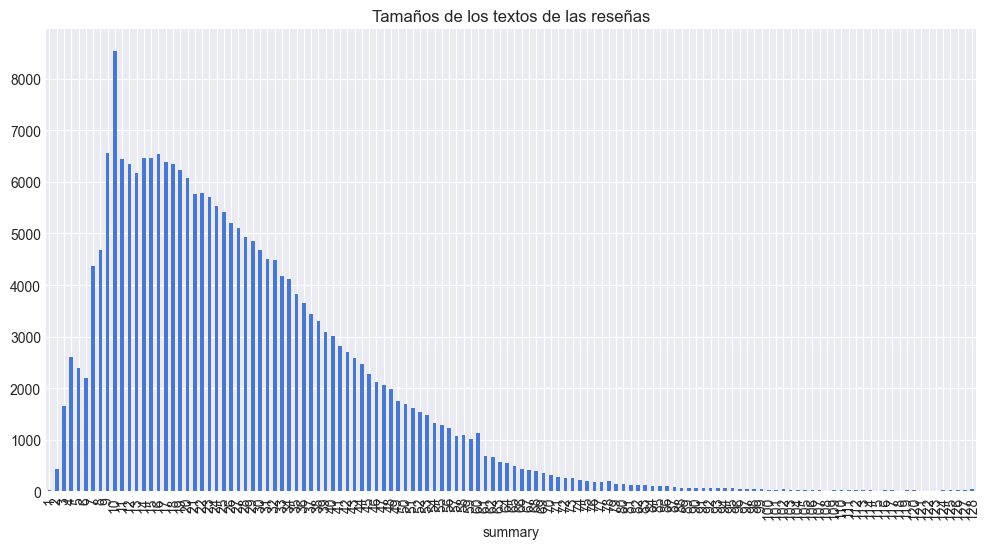

In [48]:
df["summary"].str.len().value_counts().sort_index().plot(kind="bar", figsize=(12, 6), title="Tamaños de los textos de las reseñas")  


In [49]:
df["summary"].describe()

count         231780
unique        187867
top       Great game
freq            1066
Name: summary, dtype: object

In [50]:
vacio = (df["summary"] == " ").sum()
print(f"Number of empty summaries: {vacio}")

Number of empty summaries: 0


In [51]:
df['char_len_sum'] = df.summary.str.len()
df['tok_len_sum'] = df.summary.str.split().str.len()
df[['char_len_sum','tok_len_sum']].describe(percentiles=[.05,.25,.5,.75,.95,.99])

,char_len_sum,tok_len_sum
count,231780.000000,231780.000000
mean,27.121784,4.966132
std,16.762837,3.137977
min,1.000000,1.000000
5%,7.000000,1.000000
25%,14.000000,3.000000
50%,24.000000,4.000000
75%,36.000000,7.000000
95%,58.000000,11.000000
99%,79.000000,15.000000


<Axes: xlabel='tok_len_sum', ylabel='Count'>

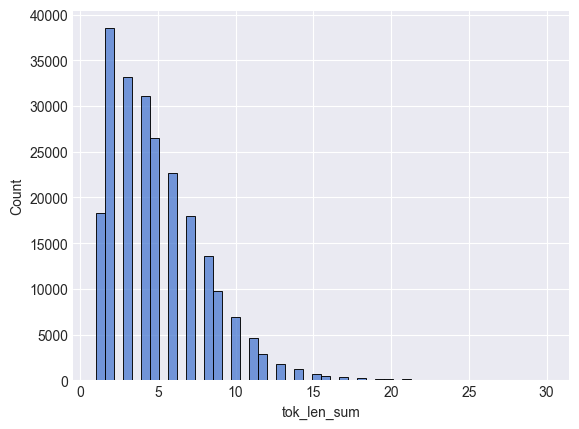

In [52]:
sns.histplot(df['tok_len_sum'], bins=50)



summary aporta una mini-reseña condensada, con vocabulario muy repetitivo y longitud ultra-corta probablemente sea útil como “sabor rápido” de sentimiento, pero necesitará limpieza de títulos genéricos para no introducir sesgo.

In [53]:
df["unixReviewTime"].describe()

count    2.317800e+05
mean     1.277217e+09
std      1.155784e+08
min      9.398592e+08
25%      1.212970e+09
50%      1.317773e+09
75%      1.368490e+09
max      1.405987e+09
Name: unixReviewTime, dtype: float64

In [54]:
df["unixReviewTime"].value_counts()

unixReviewTime
1385078400    422
1388361600    353
1384560000    349
1388448000    332
1385337600    319
             ... 
956620800       1
955324800       1
966729600       1
946425600       1
962064000       1
Name: count, Length: 5302, dtype: int64

In [55]:
df['date'] = pd.to_datetime(df.unixReviewTime, unit='s')

In [56]:
df.date.head(10)

0   2012-07-09
1   2013-06-30
2   2014-06-28
3   2011-09-14
4   2011-06-14
5   2013-05-11
6   2011-08-14
7   2012-11-24
8   2012-11-14
9   2014-02-08
Name: date, dtype: datetime64[ns]

<Axes: >

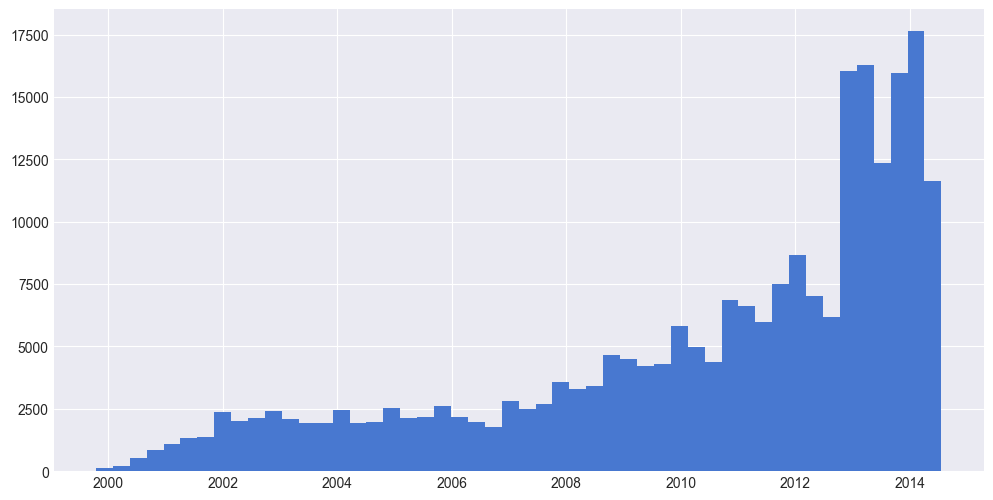

In [57]:
#histograma de date
df.date.hist(bins=50, figsize=(12, 6))


La gran mayoría del corpus es reciente (2010-2014), con un boom en 2013-2014; los registros muy antiguos son escasos

In [58]:
df.reviewTime.describe()  

count          231780
unique           5302
top       11 22, 2013
freq              422
Name: reviewTime, dtype: object

In [59]:
df.reviewTime.info()

<class 'pandas.core.series.Series'>
RangeIndex: 231780 entries, 0 to 231779
Series name: reviewTime
Non-Null Count   Dtype 
--------------   ----- 
231780 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


In [60]:
df.reviewTime.value_counts()

reviewTime
11 22, 2013    422
12 30, 2013    353
11 16, 2013    349
12 31, 2013    332
11 25, 2013    319
              ... 
04 25, 2000      1
04 10, 2000      1
08 20, 2000      1
12 29, 1999      1
06 27, 2000      1
Name: count, Length: 5302, dtype: int64

In [61]:
type(df.reviewTime[0])

str


reviewTime es una duplicación en formato string de unixReviewTime

,tok_len_rew,overall
tok_len_rew,1.000000,-0.166988
overall,-0.166988,1.000000


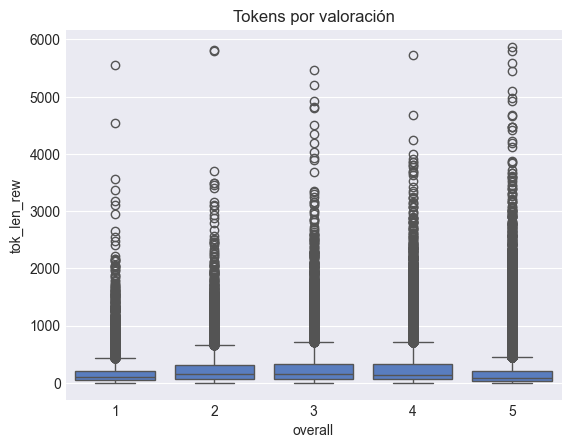

In [62]:
# Boxplot (visual)
sns.boxplot(x='overall', y='tok_len_rew', data=df)
plt.title('Tokens por valoración')

# Correlación numérica (Spearman para variables ordinales)
df[['tok_len_rew','overall']].corr(method='spearman')


Existe una correlación Spearman débil-negativa (≈ -0.17): a medida que la valoración sube, la longitud media de la reseña tiende a disminuir ligeramente.

El boxplot confirma que las diferencias son modestas (todas las medianas rondan 100-150 tokens) y que la varianza interna de cada grupo es mucho mayor que la diferencia inter-grupos.